# Dynamic Pricing Model with Deep Learning

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras plotly optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import optuna
import shap
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Setup complete! TensorFlow version:", tf.__version__)

Setup complete! TensorFlow version: 2.18.0


# Load the Online Retail Dataset
# This dataset is available from multiple sources, including Kaggle and UCI

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

# Read the dataset
try:
    retail_df = pd.read_excel('Online Retail.xlsx')
    print("Dataset loaded successfully!")
except:
    # Fallback option if direct download fails
    print("Direct download failed. Loading from a backup source.")
    # Using a sample of the dataset that's commonly available
    retail_df = pd.read_csv('https://raw.githubusercontent.com/datasets/sample-dataset/main/data/online-retail-dataset.csv')


--2025-04-23 18:25:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [        <=>         ]  22.62M  11.4MB/s    in 2.0s    

2025-04-23 18:25:23 (11.4 MB/s) - ‘Online Retail.xlsx’ saved [23715344]

Dataset loaded successfully!


In [5]:
# Display basic information about the dataset
print("\nDataset information:")
print(f"Number of records: {retail_df.shape[0]}")
print(f"Number of columns: {retail_df.shape[1]}")
print("\nColumn names:")
print(retail_df.columns.tolist())



Dataset information:
Number of records: 541909
Number of columns: 8

Column names:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [6]:
# Display the first few rows
print("\nFirst 5 rows:")
display(retail_df.head())


First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
# Check for missing values
print("\nMissing values:")
print(retail_df.isnull().sum())


Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [9]:
# Basic statistics
print("\nBasic statistics:")
display(retail_df.describe())


Basic statistics:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


# Data Preprocessing

In [10]:
# 1. Handle missing values
print("Original shape:", retail_df.shape)
retail_df = retail_df.dropna()
print("Shape after removing missing values:", retail_df.shape)


Original shape: (541909, 8)
Shape after removing missing values: (406829, 8)


In [11]:
# 2. Filter out records with negative or zero quantities and prices
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
print("Shape after filtering invalid quantities and prices:", retail_df.shape)


Shape after filtering invalid quantities and prices: (397884, 8)


In [12]:
# 3. Convert InvoiceDate to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])

In [13]:
# 4. Extract datetime features
retail_df['Year'] = retail_df['InvoiceDate'].dt.year
retail_df['Month'] = retail_df['InvoiceDate'].dt.month
retail_df['Day'] = retail_df['InvoiceDate'].dt.day
retail_df['DayOfWeek'] = retail_df['InvoiceDate'].dt.dayofweek
retail_df['Hour'] = retail_df['InvoiceDate'].dt.hour

In [14]:
# 5. Create TotalPrice feature
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [15]:
# 6. Filter out extreme outliers (using IQR method)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

retail_df = remove_outliers(retail_df, 'UnitPrice')
retail_df = remove_outliers(retail_df, 'Quantity')
print("Shape after removing outliers:", retail_df.shape)

Shape after removing outliers: (369762, 14)


In [16]:
# 7. Aggregate sales data by product and day
# This creates a time series of sales for each product
daily_sales = retail_df.groupby(['StockCode', pd.Grouper(key='InvoiceDate', freq='D')]).\
    agg({
        'Quantity': 'sum',
        'UnitPrice': 'mean',  # Average price for the day
        'TotalPrice': 'sum',
        'InvoiceNo': 'nunique'  # Number of transactions
    }).\
    reset_index()

daily_sales.rename(columns={'InvoiceNo': 'NumTransactions'}, inplace=True)


In [17]:
# 8. Keep only products with sufficient data
product_counts = daily_sales['StockCode'].value_counts()
popular_products = product_counts[product_counts >= 30].index
daily_sales_filtered = daily_sales[daily_sales['StockCode'].isin(popular_products)]
print(f"Number of products with sufficient data: {len(popular_products)}")

Number of products with sufficient data: 1990


In [18]:
# 9. Check the processed data
print("\nProcessed data (daily_sales_filtered):")
display(daily_sales_filtered.head())
print(f"Shape of daily_sales_filtered: {daily_sales_filtered.shape}")


Processed data (daily_sales_filtered):


,StockCode,InvoiceDate,Quantity,UnitPrice,TotalPrice,NumTransactions
0,10002,2010-12-01,12,0.85,10.20,1
1,10002,2010-12-03,1,0.85,0.85,1
2,10002,2010-12-05,1,0.85,0.85,1
3,10002,2010-12-06,24,0.85,20.40,1
4,10002,2010-12-08,12,0.85,10.20,1


Shape of daily_sales_filtered: (193239, 6)


In [19]:
# 10. Create a DataFrame with product information
product_info = retail_df[['StockCode', 'Description']].drop_duplicates()
print("\nSample product information:")
display(product_info.head())


Sample product information:


,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


# Exploratory Data Analysis (EDA)

In [20]:
# Set up a larger figure size for better visualization
plt.figure(figsize=(20, 12))

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

(0.0, 9.95)

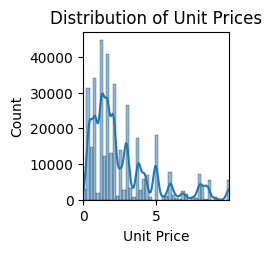

In [21]:
# 1. Overall price distribution
plt.subplot(2, 3, 1)
sns.histplot(retail_df['UnitPrice'], kde=True, bins=50)
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.xlim(0, retail_df['UnitPrice'].quantile(0.99))  # Limiting to 99th percentile for better visualization


(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

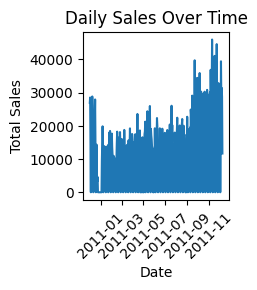

In [22]:
# 2. Sales distribution over time
plt.subplot(2, 3, 2)
daily_total = retail_df.groupby(pd.Grouper(key='InvoiceDate', freq='D'))['TotalPrice'].sum().reset_index()
plt.plot(daily_total['InvoiceDate'], daily_total['TotalPrice'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

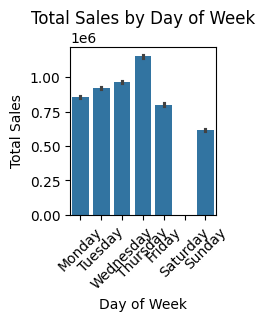

In [23]:
# 3. Sales by day of week
plt.subplot(2, 3, 3)
dow_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
retail_df['DayName'] = retail_df['DayOfWeek'].map(dow_mapping)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='DayName', y='TotalPrice', data=retail_df, order=day_order, estimator=sum)
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)


Text(0, 0.5, 'Total Sales')

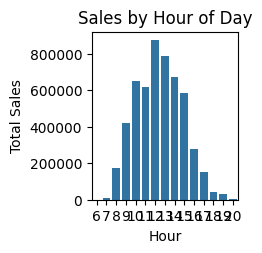

In [24]:
# 4. Sales by hour
plt.subplot(2, 3, 4)
hourly_sales = retail_df.groupby('Hour')['TotalPrice'].sum().reset_index()
sns.barplot(x='Hour', y='TotalPrice', data=hourly_sales)
plt.title('Sales by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Sales')

(0.0, 24.0)

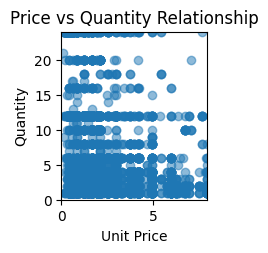

In [25]:
# 5. Price vs Quantity Relationship
plt.subplot(2, 3, 5)
# Use a sample to avoid overcrowding the plot
sample = retail_df.sample(min(5000, len(retail_df)))
plt.scatter(sample['UnitPrice'], sample['Quantity'], alpha=0.5)
plt.title('Price vs Quantity Relationship')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.xlim(0, sample['UnitPrice'].quantile(0.95))
plt.ylim(0, sample['Quantity'].quantile(0.95))

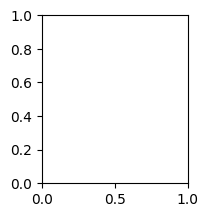

In [26]:
# 6. Price Elasticity Analysis
plt.subplot(2, 3, 6)
# Group by product and calculate average price and quantity
product_price_qty = retail_df.groupby('StockCode').agg({
    'UnitPrice': 'mean',
    'Quantity': 'mean'
}).reset_index()

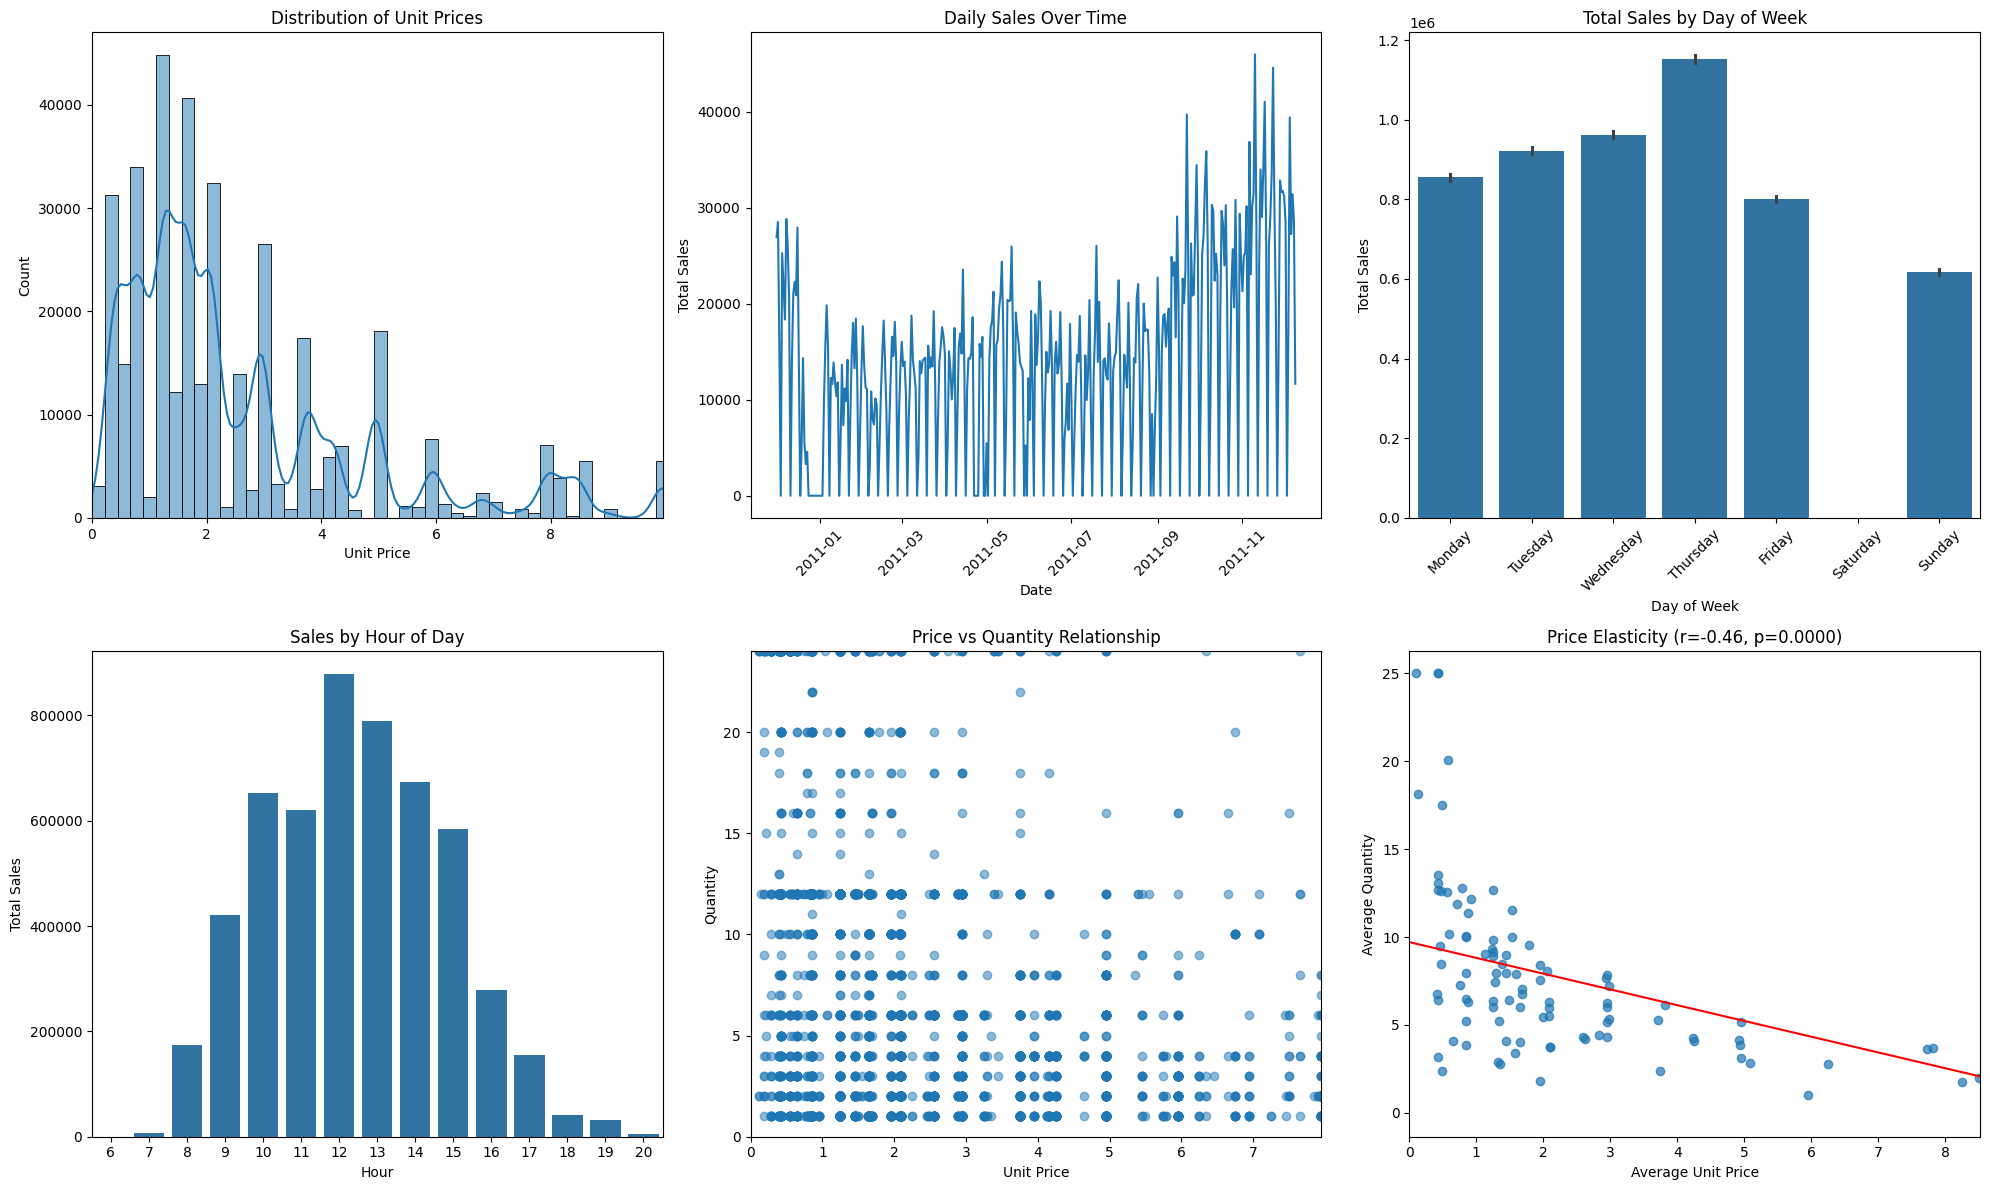

In [28]:
# Exploratory Data Analysis (EDA)

# Set up a larger figure size for better visualization
plt.figure(figsize=(20, 12))

# 1. Overall price distribution
plt.subplot(2, 3, 1)
sns.histplot(retail_df['UnitPrice'], kde=True, bins=50)
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.xlim(0, retail_df['UnitPrice'].quantile(0.99))  # Limiting to 99th percentile for better visualization

# 2. Sales distribution over time
plt.subplot(2, 3, 2)
daily_total = retail_df.groupby(pd.Grouper(key='InvoiceDate', freq='D'))['TotalPrice'].sum().reset_index()
plt.plot(daily_total['InvoiceDate'], daily_total['TotalPrice'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# 3. Sales by day of week
plt.subplot(2, 3, 3)
dow_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
retail_df['DayName'] = retail_df['DayOfWeek'].map(dow_mapping)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='DayName', y='TotalPrice', data=retail_df, order=day_order, estimator=sum)
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# 4. Sales by hour
plt.subplot(2, 3, 4)
hourly_sales = retail_df.groupby('Hour')['TotalPrice'].sum().reset_index()
sns.barplot(x='Hour', y='TotalPrice', data=hourly_sales)
plt.title('Sales by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Sales')

# 5. Price vs Quantity Relationship
plt.subplot(2, 3, 5)
# Use a sample to avoid overcrowding the plot
sample = retail_df.sample(min(5000, len(retail_df)))
plt.scatter(sample['UnitPrice'], sample['Quantity'], alpha=0.5)
plt.title('Price vs Quantity Relationship')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.xlim(0, sample['UnitPrice'].quantile(0.95))
plt.ylim(0, sample['Quantity'].quantile(0.95))

# 6. Price Elasticity Analysis
plt.subplot(2, 3, 6)
# Group by product and calculate average price and quantity
product_price_qty = retail_df.groupby('StockCode').agg({
    'UnitPrice': 'mean',
    'Quantity': 'mean'
}).reset_index()

# Sample for better visualization
product_sample = product_price_qty.sample(min(100, len(product_price_qty)))
plt.scatter(product_sample['UnitPrice'], product_sample['Quantity'], alpha=0.7)

# Add trend line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    product_sample['UnitPrice'], product_sample['Quantity'])
x = np.linspace(0, product_sample['UnitPrice'].max(), 100)
y = slope * x + intercept
plt.plot(x, y, 'r-')
plt.title(f'Price Elasticity (r={r_value:.2f}, p={p_value:.4f})')
plt.xlabel('Average Unit Price')
plt.ylabel('Average Quantity')
plt.xlim(0, product_sample['UnitPrice'].quantile(0.95))

plt.tight_layout()
plt.show()

In [29]:
# 7. Interactive time series visualization with Plotly
# Select a few popular products for visualization
top_products = daily_sales_filtered['StockCode'].value_counts().head(5).index

# Create an interactive plot
fig = go.Figure()

for product in top_products:
    product_data = daily_sales_filtered[daily_sales_filtered['StockCode'] == product]
    product_name = product_info[product_info['StockCode'] == product]['Description'].values[0][:20] + '...'

    fig.add_trace(go.Scatter(
        x=product_data['InvoiceDate'],
        y=product_data['UnitPrice'],
        mode='lines+markers',
        name=f"{product} - {product_name}"
    ))

fig.update_layout(
    title='Price Trends Over Time for Popular Products',
    xaxis_title='Date',
    yaxis_title='Unit Price',
    legend_title='Products',
    height=600,
    width=1000
)

fig.show()


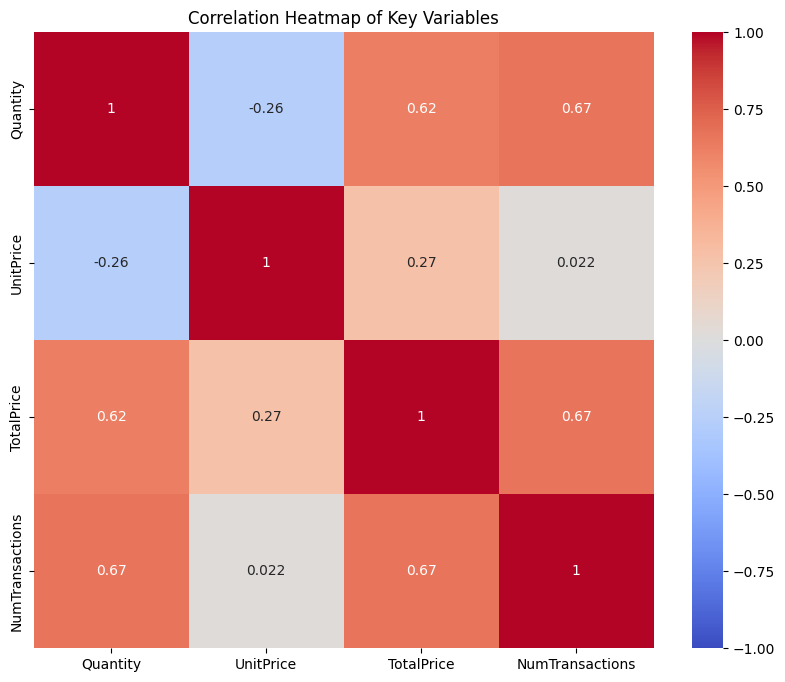

In [30]:
# 8. Correlation heatmap for key variables
# Create a subset of numerical columns
numeric_data = daily_sales_filtered[['Quantity', 'UnitPrice', 'TotalPrice', 'NumTransactions']]

# Calculate correlation matrix
corr_matrix = numeric_data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Variables')
plt.show()

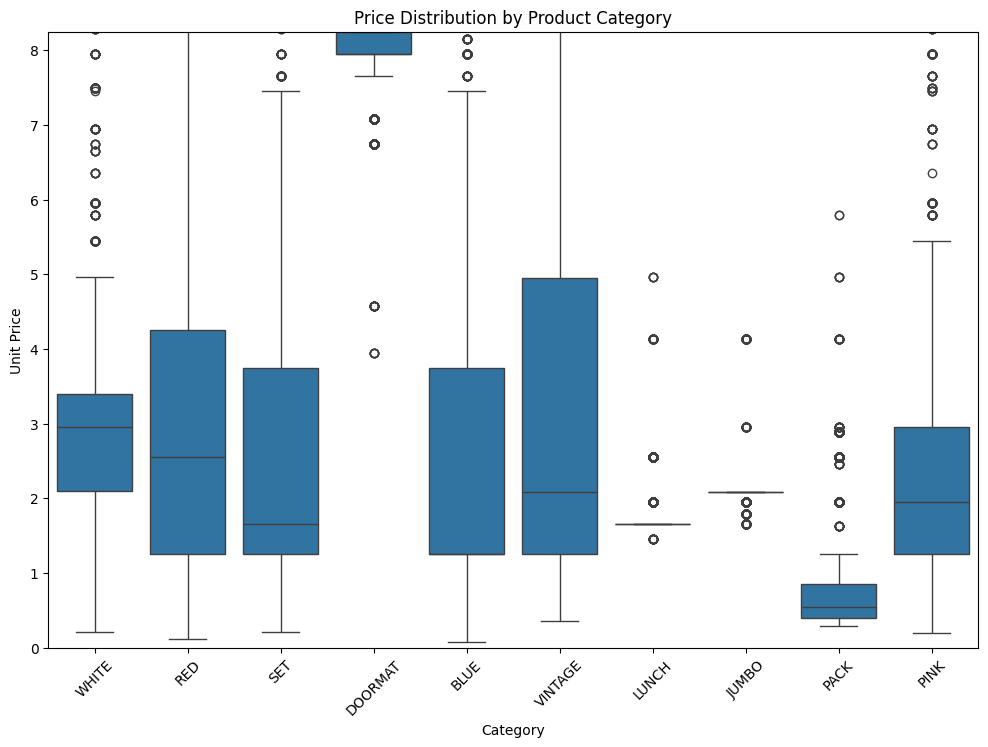

In [31]:
# 9. Price distribution by product category
# Extract product category from description
def extract_category(description):
    if pd.isna(description):
        return 'Unknown'
    words = description.split()
    if len(words) > 0:
        return words[0]
    return 'Unknown'

retail_df['Category'] = retail_df['Description'].apply(extract_category)

# Plot price distribution by top categories
top_categories = retail_df['Category'].value_counts().head(10).index
category_data = retail_df[retail_df['Category'].isin(top_categories)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='UnitPrice', data=category_data)
plt.title('Price Distribution by Product Category')
plt.xlabel('Category')
plt.ylabel('Unit Price')
plt.xticks(rotation=45)
plt.ylim(0, category_data['UnitPrice'].quantile(0.95))
plt.show()

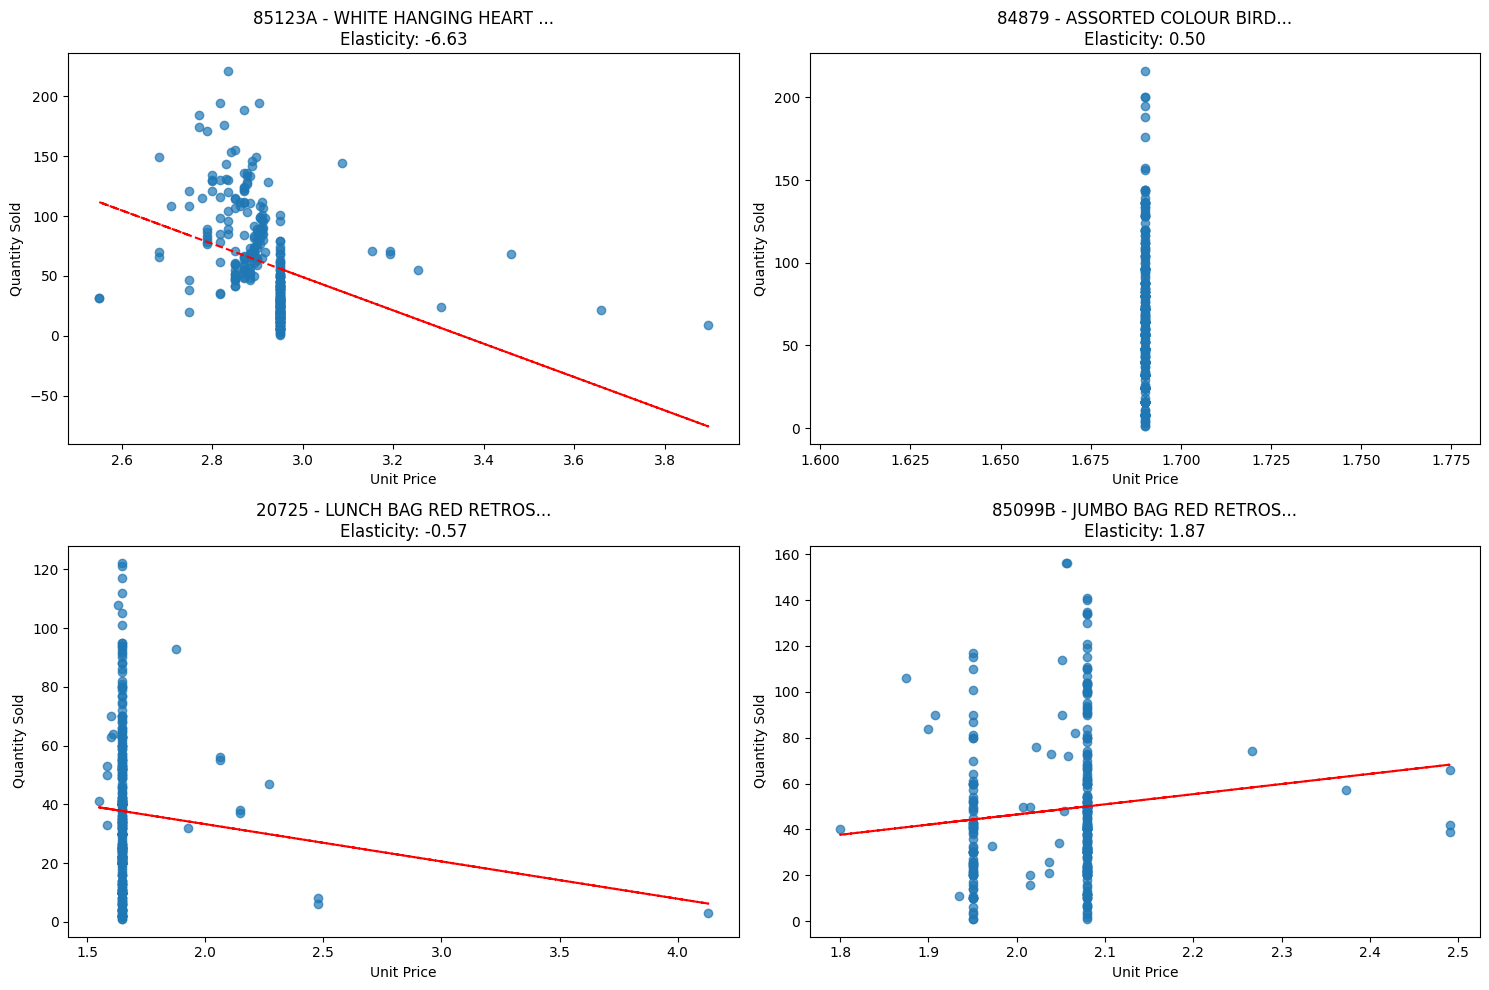

In [32]:
# 10. Price sensitivity analysis: how quantity changes with price
plt.figure(figsize=(15, 10))

# Select a few products for analysis
for i, product in enumerate(top_products[:4]):
    product_data = daily_sales_filtered[daily_sales_filtered['StockCode'] == product]

    plt.subplot(2, 2, i+1)
    plt.scatter(product_data['UnitPrice'], product_data['Quantity'], alpha=0.7)

    # Add trend line
    try:
        z = np.polyfit(product_data['UnitPrice'], product_data['Quantity'], 1)
        p = np.poly1d(z)
        plt.plot(product_data['UnitPrice'], p(product_data['UnitPrice']), "r--")

        # Calculate elasticity
        avg_price = product_data['UnitPrice'].mean()
        avg_quantity = product_data['Quantity'].mean()
        elasticity = (z[0] * avg_price) / avg_quantity

        product_name = product_info[product_info['StockCode'] == product]['Description'].values[0][:20] + '...'
        plt.title(f'{product} - {product_name}\nElasticity: {elasticity:.2f}')
    except:
        plt.title(f'{product} - Insufficient data for elasticity calculation')

    plt.xlabel('Unit Price')
    plt.ylabel('Quantity Sold')

plt.tight_layout()
plt.show()

# Feature Engineering


In [33]:
# 1. Select a single product for detailed analysis and modeling
# Let's pick the product with the most data points
product_counts = daily_sales_filtered['StockCode'].value_counts()
target_product = product_counts.index[0]
product_name = product_info[product_info['StockCode'] == target_product]['Description'].values[0]

print(f"Selected product for modeling: {target_product} - {product_name}")
print(f"Number of data points: {product_counts[target_product]}")

# Get data for the selected product
product_data = daily_sales_filtered[daily_sales_filtered['StockCode'] == target_product].copy()
product_data = product_data.sort_values('InvoiceDate')


Selected product for modeling: 85123A - WHITE HANGING HEART T-LIGHT HOLDER
Number of data points: 304


In [34]:
# 2. Create lag features (previous day's values)
# Lag price
product_data['Price_Lag1'] = product_data['UnitPrice'].shift(1)
product_data['Price_Lag2'] = product_data['UnitPrice'].shift(2)
product_data['Price_Lag3'] = product_data['UnitPrice'].shift(3)

# Lag quantity
product_data['Quantity_Lag1'] = product_data['Quantity'].shift(1)
product_data['Quantity_Lag2'] = product_data['Quantity'].shift(2)
product_data['Quantity_Lag3'] = product_data['Quantity'].shift(3)

# Lag transactions
product_data['Transactions_Lag1'] = product_data['NumTransactions'].shift(1)

In [35]:
# 3. Create rolling window features
product_data['Price_Rolling_Mean_7'] = product_data['UnitPrice'].rolling(window=7).mean()
product_data['Quantity_Rolling_Mean_7'] = product_data['Quantity'].rolling(window=7).mean()
product_data['Price_Rolling_Std_7'] = product_data['UnitPrice'].rolling(window=7).std()


In [36]:
# 4. Create day of week features (one-hot encoded)
dow_dummies = pd.get_dummies(product_data['InvoiceDate'].dt.dayofweek, prefix='DOW')
product_data = pd.concat([product_data, dow_dummies], axis=1)


In [37]:
# 5. Create month and quarter features
product_data['Month'] = product_data['InvoiceDate'].dt.month
product_data['Quarter'] = product_data['InvoiceDate'].dt.quarter
month_dummies = pd.get_dummies(product_data['Month'], prefix='Month')
product_data = pd.concat([product_data, month_dummies], axis=1)

In [38]:
# 6. Create features for special days (e.g., weekends, holidays)
product_data['IsWeekend'] = product_data['InvoiceDate'].dt.dayofweek >= 5

In [39]:
# 7. Calculate price change from previous day
product_data['Price_Change'] = product_data['UnitPrice'] - product_data['Price_Lag1']
product_data['Price_Change_Pct'] = product_data['Price_Change'] / product_data['Price_Lag1'] * 100

In [40]:
# 8. Calculate quantity change from previous day
product_data['Quantity_Change'] = product_data['Quantity'] - product_data['Quantity_Lag1']
product_data['Quantity_Change_Pct'] = product_data['Quantity_Change'] / product_data['Quantity_Lag1'] * 100

In [41]:
# 9. Calculate moving average convergence divergence (MACD) - a common technical indicator
product_data['Price_EMA12'] = product_data['UnitPrice'].ewm(span=12).mean()
product_data['Price_EMA26'] = product_data['UnitPrice'].ewm(span=26).mean()
product_data['Price_MACD'] = product_data['Price_EMA12'] - product_data['Price_EMA26']
product_data['Price_MACD_Signal'] = product_data['Price_MACD'].ewm(span=9).mean()


In [42]:
# 10. Create historical mean prices
product_data['Price_Historic_Mean'] = product_data['UnitPrice'].expanding().mean()
product_data['Price_Historic_Std'] = product_data['UnitPrice'].expanding().std()

In [43]:
# 11. Seasonality - day of year feature
product_data['DayOfYear'] = product_data['InvoiceDate'].dt.dayofyear
product_data['DayOfYear_Sin'] = np.sin(2 * np.pi * product_data['DayOfYear']/365)
product_data['DayOfYear_Cos'] = np.cos(2 * np.pi * product_data['DayOfYear']/365)

In [44]:
# 12. Create weekend peak features
product_data['IsWeekend_Lag1'] = product_data['IsWeekend'].shift(1)
product_data['IsWeekend_Lag2'] = product_data['IsWeekend'].shift(2)


In [45]:
# 13. Drop rows with NaN values (from lag features)
product_data_clean = product_data.dropna()

In [46]:
print(f"Shape after creating features: {product_data_clean.shape}")
print(f"Available features: {product_data_clean.columns.tolist()}")

Shape after creating features: (298, 52)
Available features: ['StockCode', 'InvoiceDate', 'Quantity', 'UnitPrice', 'TotalPrice', 'NumTransactions', 'Price_Lag1', 'Price_Lag2', 'Price_Lag3', 'Quantity_Lag1', 'Quantity_Lag2', 'Quantity_Lag3', 'Transactions_Lag1', 'Price_Rolling_Mean_7', 'Quantity_Rolling_Mean_7', 'Price_Rolling_Std_7', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_6', 'Month', 'Quarter', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'IsWeekend', 'Price_Change', 'Price_Change_Pct', 'Quantity_Change', 'Quantity_Change_Pct', 'Price_EMA12', 'Price_EMA26', 'Price_MACD', 'Price_MACD_Signal', 'Price_Historic_Mean', 'Price_Historic_Std', 'DayOfYear', 'DayOfYear_Sin', 'DayOfYear_Cos', 'IsWeekend_Lag1', 'IsWeekend_Lag2']


In [47]:
# Display the first few rows of the feature-engineered data
display(product_data_clean.head())


,StockCode,InvoiceDate,Quantity,UnitPrice,TotalPrice,NumTransactions,Price_Lag1,Price_Lag2,Price_Lag3,Quantity_Lag1,...,Price_EMA26,Price_MACD,Price_MACD_Signal,Price_Historic_Mean,Price_Historic_Std,DayOfYear,DayOfYear_Sin,DayOfYear_Cos,IsWeekend_Lag1,IsWeekend_Lag2
206934,85123A,2010-12-08,149,2.896667,413.95,14,2.816667,2.877273,2.916667,194.0,...,2.848073,0.006534,0.005607,2.841515,0.096394,342,-0.385663,0.922640,False,False
206935,85123A,2010-12-09,188,2.870000,516.20,15,2.896667,2.816667,2.877273,149.0,...,2.851606,0.006213,0.005753,2.845076,0.089810,343,-0.369725,0.929141,False,False
206936,85123A,2010-12-10,88,2.910000,246.80,10,2.870000,2.896667,2.816667,188.0,...,2.860261,0.007881,0.006244,2.852290,0.086752,344,-0.353676,0.935368,False,False
206937,85123A,2010-12-12,42,2.950000,123.90,11,2.910000,2.870000,2.896667,88.0,...,2.872644,0.011010,0.007312,2.862061,0.087433,346,-0.321270,0.946988,False,False
206938,85123A,2010-12-13,143,2.830000,383.45,10,2.950000,2.910000,2.870000,42.0,...,2.867113,0.006724,0.007183,2.859146,0.083507,347,-0.304921,0.952378,True,False


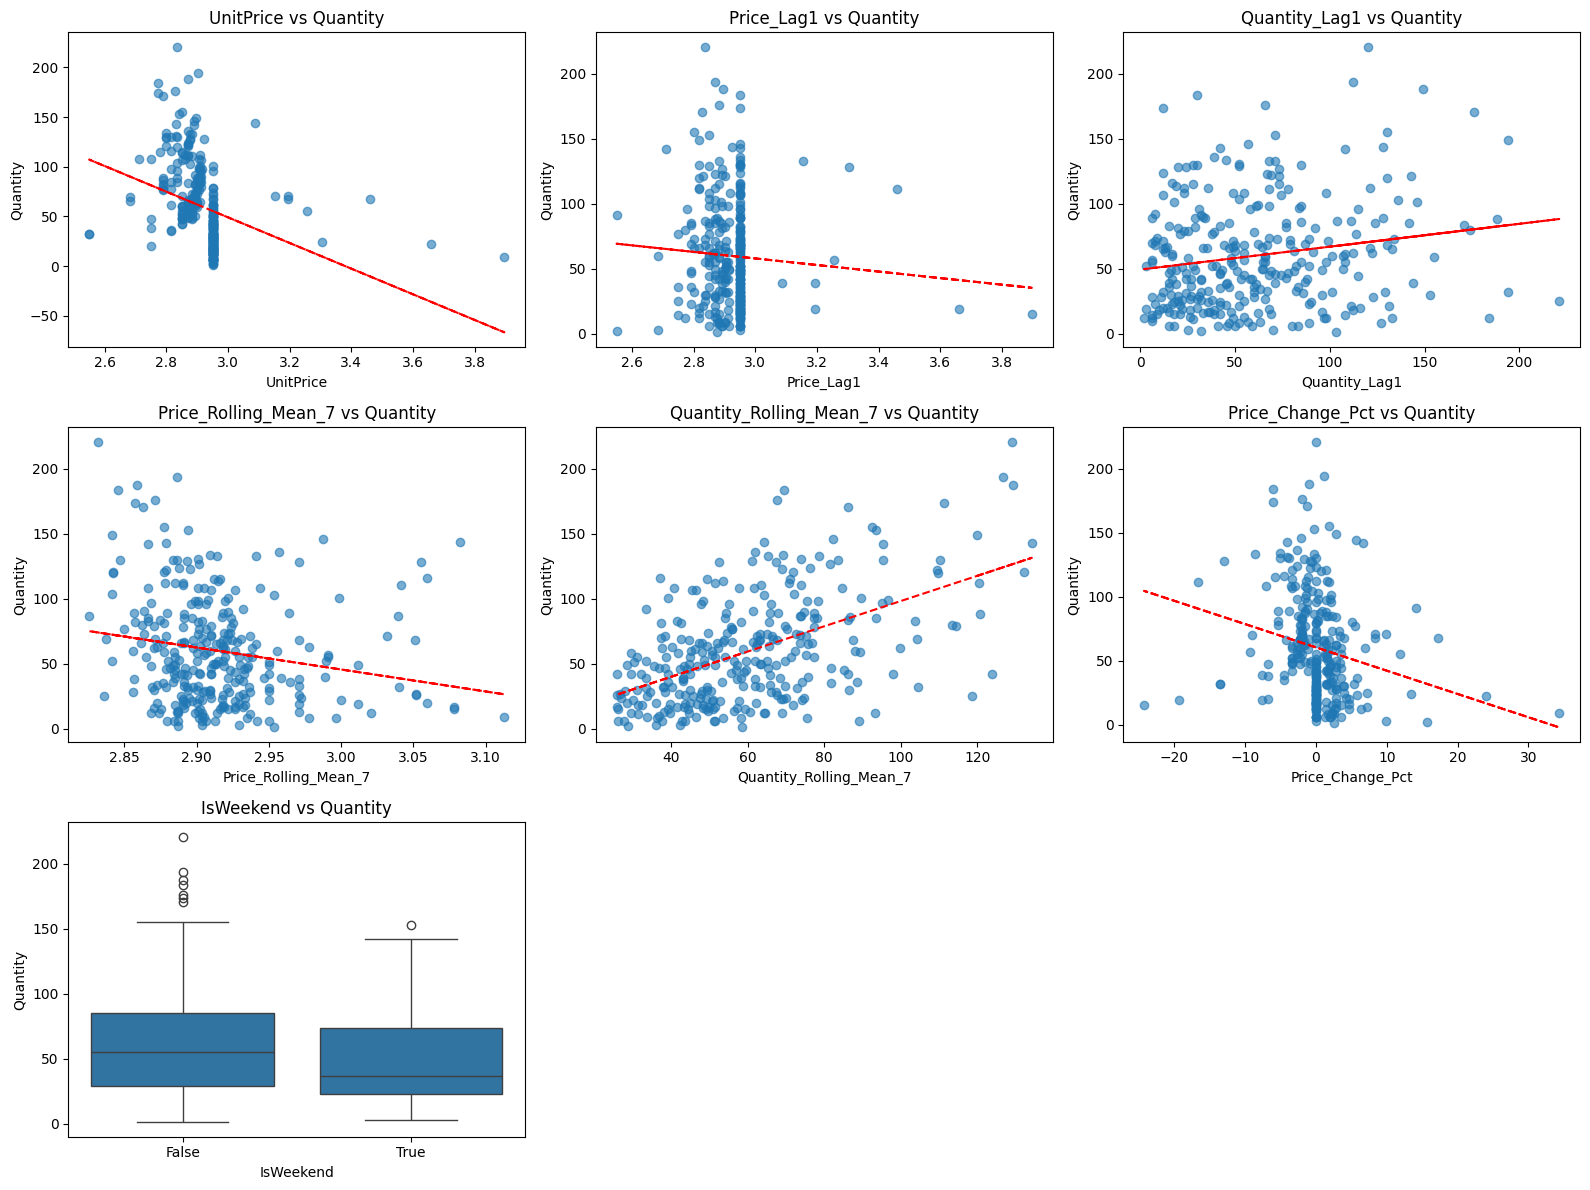

In [48]:
# Visualize relationship between features and target (Quantity)
plt.figure(figsize=(16, 12))

# Key features to analyze
features_to_plot = [
    'UnitPrice', 'Price_Lag1', 'Quantity_Lag1', 'Price_Rolling_Mean_7',
    'Quantity_Rolling_Mean_7', 'Price_Change_Pct', 'IsWeekend'
]

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 3, i+1)

    if feature == 'IsWeekend':
        sns.boxplot(x=feature, y='Quantity', data=product_data_clean)
    else:
        plt.scatter(product_data_clean[feature], product_data_clean['Quantity'], alpha=0.6)

        # Add trend line
        try:
            z = np.polyfit(product_data_clean[feature], product_data_clean['Quantity'], 1)
            p = np.poly1d(z)
            plt.plot(product_data_clean[feature], p(product_data_clean[feature]), "r--")
        except:
            pass

    plt.title(f'{feature} vs Quantity')
    plt.xlabel(feature)
    plt.ylabel('Quantity')

plt.tight_layout()
plt.show()

In [52]:
# Calculate correlation of features with target (Quantity)
# Select only numerical features for correlation calculation
numerical_features = product_data_clean.select_dtypes(include=np.number)  # Select numerical columns

corr_with_quantity = numerical_features.corr()['Quantity'].sort_values(ascending=False)
print("\nCorrelation with Quantity:")
print(corr_with_quantity)


Correlation with Quantity:
Quantity                   1.000000
TotalPrice                 0.998564
NumTransactions            0.790127
Quantity_Change            0.634573
Quantity_Rolling_Mean_7    0.527101
Quantity_Change_Pct        0.352176
Quantity_Lag1              0.178565
Quantity_Lag2              0.166005
Transactions_Lag1          0.157791
Quantity_Lag3              0.126382
DayOfYear_Cos              0.125394
DayOfYear_Sin              0.090002
Price_Historic_Std         0.059691
Quarter                   -0.000331
Month                     -0.001014
DayOfYear                 -0.007732
Price_Lag3                -0.017406
Price_Lag2                -0.023660
Price_Rolling_Std_7       -0.025805
Price_Lag1                -0.066080
Price_EMA26               -0.135532
Price_MACD_Signal         -0.156364
Price_Rolling_Mean_7      -0.190519
Price_Historic_Mean       -0.197075
Price_Change              -0.197083
Price_EMA12               -0.206274
Price_Change_Pct          -0.214237


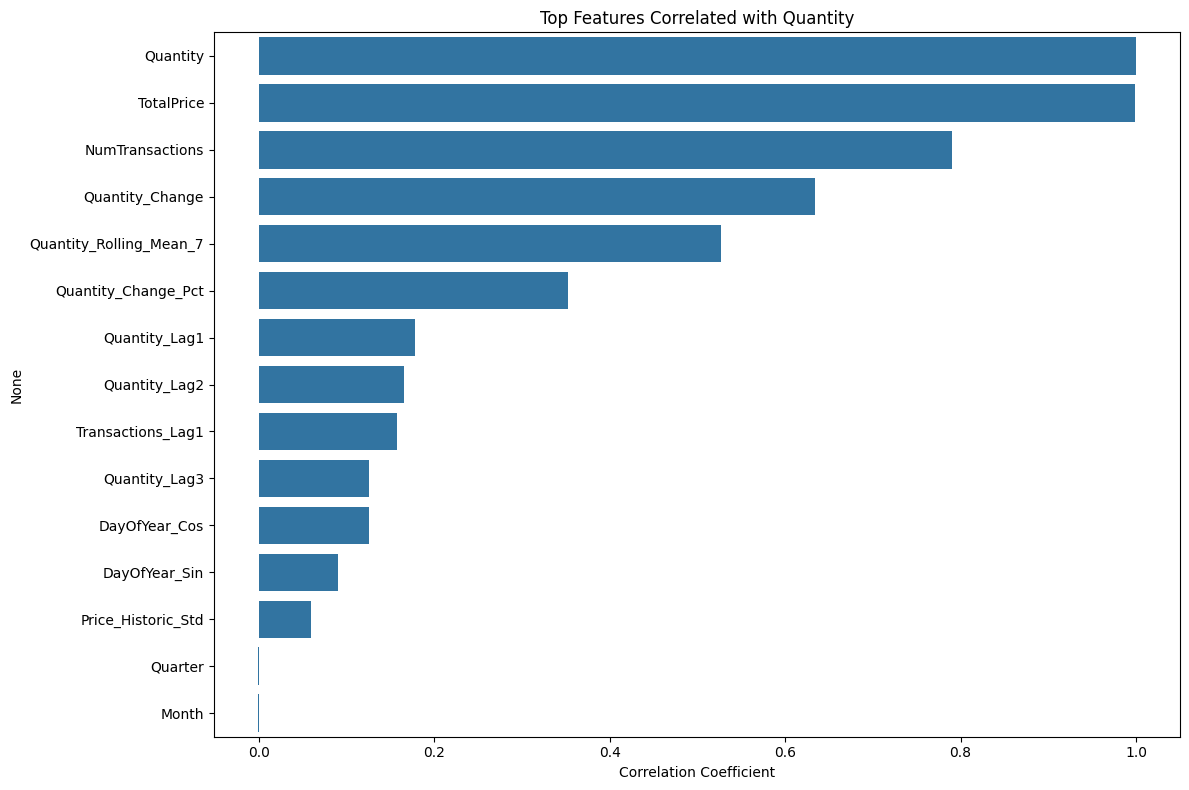

In [53]:
# Visualize top correlated features
plt.figure(figsize=(12, 8))
top_corrs = corr_with_quantity.iloc[:15]
sns.barplot(x=top_corrs.values, y=top_corrs.index)
plt.title('Top Features Correlated with Quantity')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


# Model Preparation

In [54]:
# Define features and target
# First, let's establish that our goal is to predict quantity based on price and other features
# This will help us determine the optimal price later


In [55]:
# 1. Define features and target
# We'll exclude non-feature columns and target from our features list
non_feature_cols = ['StockCode', 'InvoiceDate', 'TotalPrice', 'Quantity', 'Month', 'Quarter', 'DayOfYear']
X = product_data_clean.drop(non_feature_cols, axis=1)
y = product_data_clean['Quantity']  # Target is the quantity sold

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (298, 45)
Target vector shape: (298,)


In [56]:
# 2. Split the data into training and testing sets (chronologically)
# Since this is time series data, we'll use the last 20% for testing
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 238 samples
Testing set: 60 samples


In [57]:
# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
# 4. Display the first few rows of scaled data
print("\nFirst 5 rows of scaled training data:")
scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
display(scaled_df.head())


First 5 rows of scaled training data:


,UnitPrice,NumTransactions,Price_Lag1,Price_Lag2,Price_Lag3,Quantity_Lag1,Quantity_Lag2,Quantity_Lag3,Transactions_Lag1,Price_Rolling_Mean_7,...,Price_EMA12,Price_EMA26,Price_MACD,Price_MACD_Signal,Price_Historic_Mean,Price_Historic_Std,DayOfYear_Sin,DayOfYear_Cos,IsWeekend_Lag1,IsWeekend_Lag2
0,-0.018481,2.724577,-1.207138,-0.308756,0.277821,3.078704,1.718975,0.197884,2.040630,-2.215849,...,-2.142184,-3.316762,0.599552,0.713688,-4.797219,5.346301,-0.835855,1.518389,-0.442696,-0.442696
1,-0.416911,3.060214,-0.015092,-1.214428,-0.310829,2.036082,3.054826,1.717869,2.708677,-1.539321,...,-1.979630,-3.070741,0.563261,0.737664,-4.452372,4.244875,-0.811964,1.527567,-0.442696,-0.442696
2,0.180734,1.382032,-0.412440,-0.018941,-1.216445,2.939688,2.018390,3.053613,3.042700,-0.261435,...,-1.457249,-2.468037,0.752028,0.818576,-3.753711,3.733358,-0.787910,1.536356,-0.442696,-0.442696
3,0.778379,1.717668,0.183583,-0.417436,-0.021032,0.622750,2.916635,2.017260,1.372583,-0.261435,...,-0.672306,-1.605753,1.106136,0.994286,-2.807380,3.847179,-0.739336,1.552758,-0.442696,-0.442696
4,-1.014555,1.382032,0.779606,0.180307,-0.419503,-0.443041,0.613443,2.915432,1.706607,-0.750039,...,-1.169090,-1.990894,0.621022,0.973097,-3.089661,3.190516,-0.714831,1.560366,2.258886,-0.442696


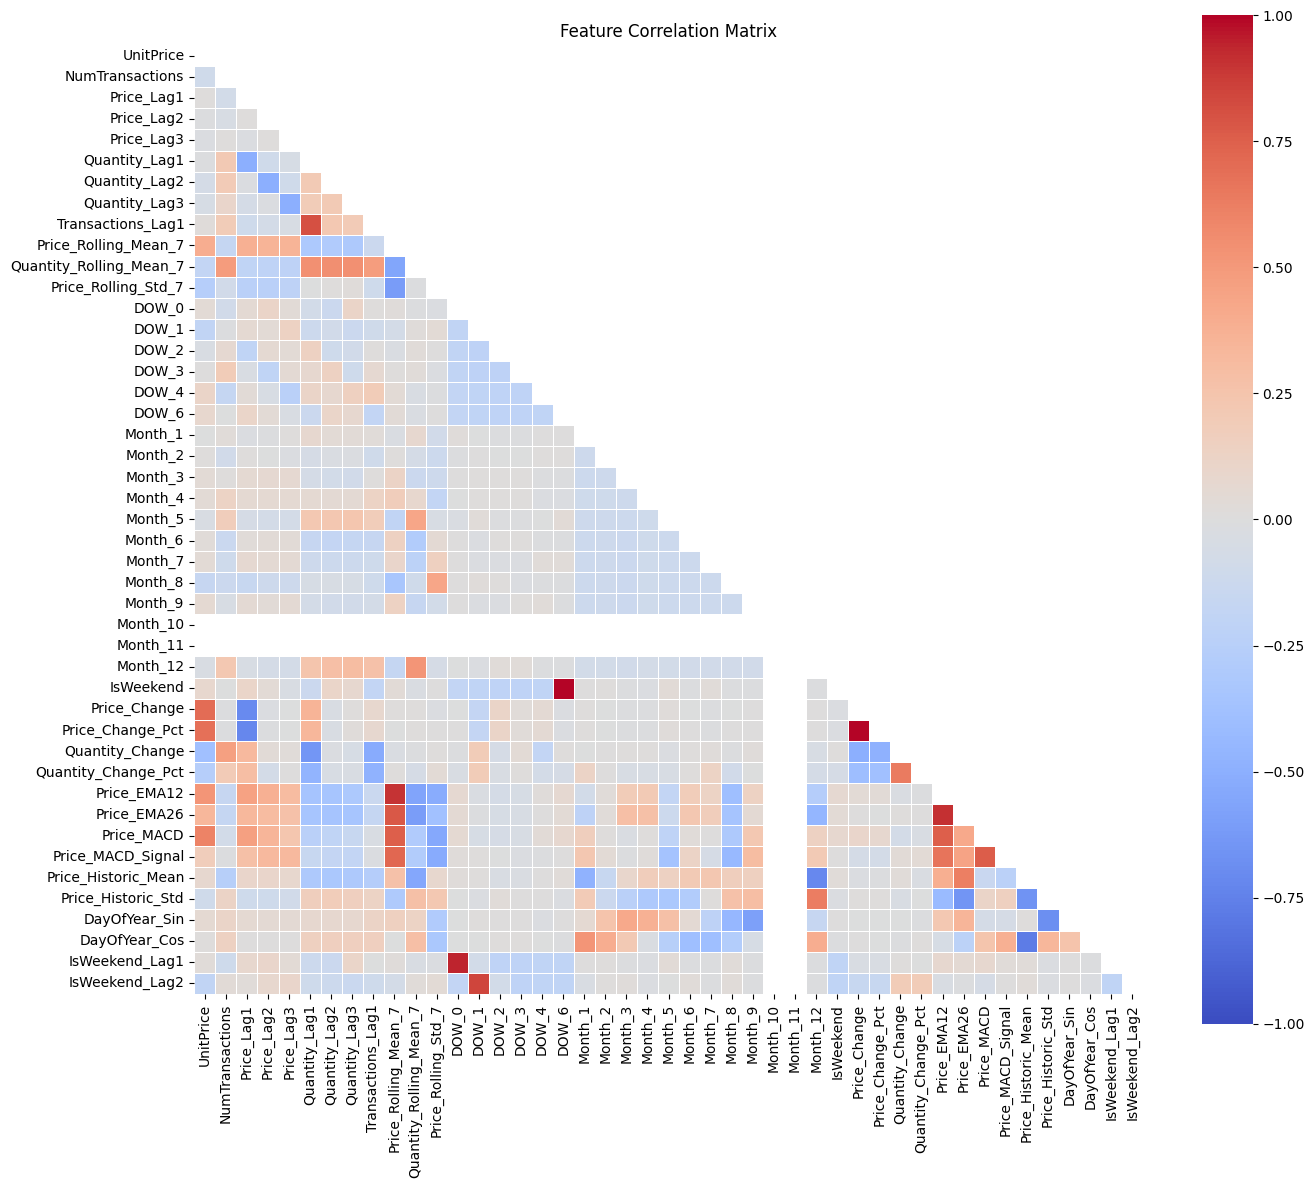

In [59]:
# 5. Checking for highly correlated features (multicollinearity)
plt.figure(figsize=(14, 12))
corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [60]:
# Identify highly correlated features
high_corr_threshold = 0.9
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_features.append((colname_i, colname_j, corr_matrix.iloc[i, j]))

print(f"\nHighly correlated features (|r| > {high_corr_threshold}):")
for feature1, feature2, corr in high_corr_features:
    print(f"{feature1} and {feature2}: {corr:.4f}")



Highly correlated features (|r| > 0.9):
IsWeekend and DOW_6: 1.0000
Price_Change_Pct and Price_Change: 0.9988
Price_EMA12 and Price_Rolling_Mean_7: 0.9026
Price_EMA26 and Price_EMA12: 0.9138
IsWeekend_Lag1 and DOW_0: 0.9380


In [61]:
# Function to remove features with high multicollinearity
def remove_multicollinear_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} features due to multicollinearity: {to_drop}")
    return X.drop(to_drop, axis=1)


In [62]:
# Apply the function to remove multicollinear features
X_train_reduced = remove_multicollinear_features(X_train, threshold=0.9)
X_test_reduced = X_test[X_train_reduced.columns]


Dropping 5 features due to multicollinearity: ['IsWeekend', 'Price_Change_Pct', 'Price_EMA12', 'Price_EMA26', 'IsWeekend_Lag1']


In [63]:
print(f"\nReduced feature matrix shape: {X_train_reduced.shape}")


Reduced feature matrix shape: (238, 40)


In [64]:
# Scale the reduced features
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)


In [65]:
# 6. Define a function to convert the preprocessed data to tensors for deep learning
def create_tensors(X, y):
    return tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y.values.reshape(-1, 1), dtype=tf.float32)

# Create TensorFlow datasets
X_train_tensor, y_train_tensor = create_tensors(X_train_reduced_scaled, y_train)
X_test_tensor, y_test_tensor = create_tensors(X_test_reduced_scaled, y_test)

In [66]:
# 7. Verify tensors
print("\nTensorFlow Tensors:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


TensorFlow Tensors:
X_train_tensor shape: (238, 40)
y_train_tensor shape: (238, 1)
X_test_tensor shape: (60, 40)
y_test_tensor shape: (60, 1)


In [67]:
# 8. Create feature names list for later use
feature_names = X_train_reduced.columns.tolist()
print(f"\nFinal feature list ({len(feature_names)} features):")
print(feature_names)


Final feature list (40 features):
['UnitPrice', 'NumTransactions', 'Price_Lag1', 'Price_Lag2', 'Price_Lag3', 'Quantity_Lag1', 'Quantity_Lag2', 'Quantity_Lag3', 'Transactions_Lag1', 'Price_Rolling_Mean_7', 'Quantity_Rolling_Mean_7', 'Price_Rolling_Std_7', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Price_Change', 'Quantity_Change', 'Quantity_Change_Pct', 'Price_MACD', 'Price_MACD_Signal', 'Price_Historic_Mean', 'Price_Historic_Std', 'DayOfYear_Sin', 'DayOfYear_Cos', 'IsWeekend_Lag2']


# Deep Learning Model for Dynamic Pricing

In [68]:
# 1. Define baseline models for comparison
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_reduced_scaled, y_train)
lr_predictions = lr_model.predict(X_test_reduced_scaled)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print("Linear Regression Performance:")
print(f"MSE: {lr_mse:.4f}")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R²: {lr_r2:.4f}")

Linear Regression Performance:
MSE: 0.0000
RMSE: 0.0000
MAE: 0.0000
R²: 1.0000


In [69]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reduced_scaled, y_train)
rf_predictions = rf_model.predict(X_test_reduced_scaled)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("\nRandom Forest Performance:")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R²: {rf_r2:.4f}")


Random Forest Performance:
MSE: 321.5039
RMSE: 17.9305
MAE: 12.7420
R²: 0.7835


In [70]:
# XGBoost Regression
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_reduced_scaled, y_train)
xgb_predictions = xgb_model.predict(X_test_reduced_scaled)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("\nXGBoost Performance:")
print(f"MSE: {xgb_mse:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R²: {xgb_r2:.4f}")



XGBoost Performance:
MSE: 266.6573
RMSE: 16.3296
MAE: 11.7637
R²: 0.8204


In [71]:
# 2. Build a deep neural network model
def create_dnn_model(input_dim, learning_rate=0.001):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)  # Output layer (no activation for regression)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [72]:
# Create DNN model
input_dim = X_train_reduced_scaled.shape[1]
dnn_model = create_dnn_model(input_dim)

In [73]:
# Print model summary
dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,697 (22.25 KB)

 Trainable params: 5,473 (21.38 KB)

 Non-trainable params: 224 (896.00 B)

In [74]:
# 3. Create a TensorFlow dataset for batch training
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_tensor)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor))
test_dataset = test_dataset.batch(batch_size)


In [75]:
# 4. Define callbacks for training
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001
)

In [76]:
# 5. Train the model
history = dnn_model.fit(
    train_dataset,
    epochs=200,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 5356.7402 - mae: 59.7335 - val_loss: 4817.6846 - val_mae: 57.8171 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5096.2681 - mae: 59.5407 - val_loss: 4801.5601 - val_mae: 57.7530 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5708.5762 - mae: 63.4968 - val_loss: 4795.9624 - val_mae: 57.8349 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5304.3848 - mae: 59.6341 - val_loss: 4795.8071 - val_mae: 58.0249 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6146.5884 - mae: 64.8615 - val_loss: 4791.3076 - val_mae: 58.2081 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5582.3638 - mae: 61.7642 - val_loss: 4786.9902 - val_mae: 58.4264 - learning_rate: 0.0010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5975.2314 - mae: 63.6743 - val_loss: 4785.2847

In [77]:
# 6. Evaluate the model
dnn_loss, dnn_mae = dnn_model.evaluate(test_dataset)
print(f"\nDeep Neural Network Performance:")
print(f"MSE (Loss): {dnn_loss:.4f}")
print(f"RMSE: {np.sqrt(dnn_loss):.4f}")
print(f"MAE: {dnn_mae:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3257.0110 - mae: 51.2946

Deep Neural Network Performance:
MSE (Loss): 3781.0396
RMSE: 61.4902
MAE: 55.2203


In [78]:
# Make predictions
dnn_predictions = dnn_model.predict(X_test_tensor)
dnn_r2 = r2_score(y_test, dnn_predictions)
print(f"R²: {dnn_r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
R²: -1.5467


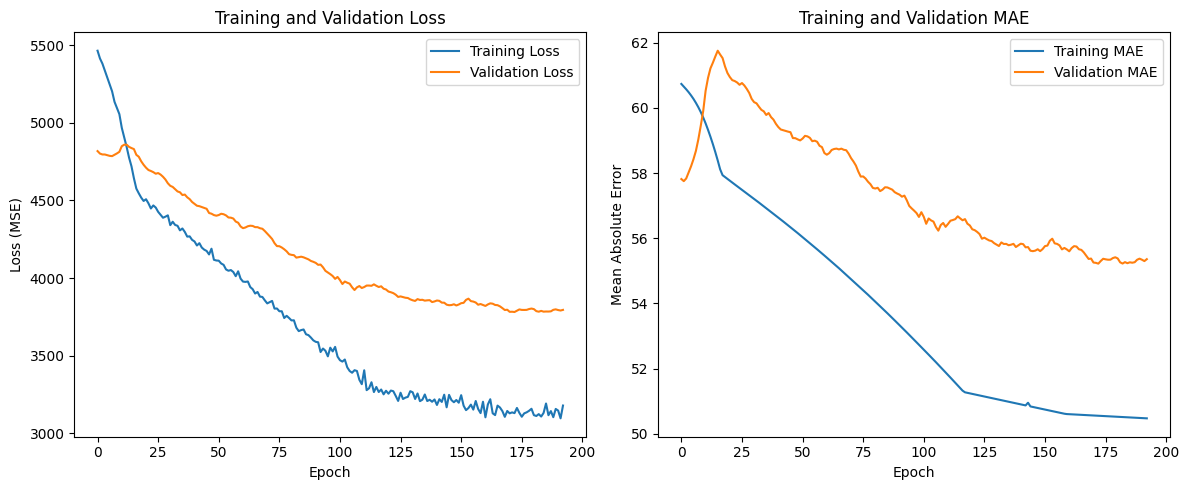

In [79]:
# 7. Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

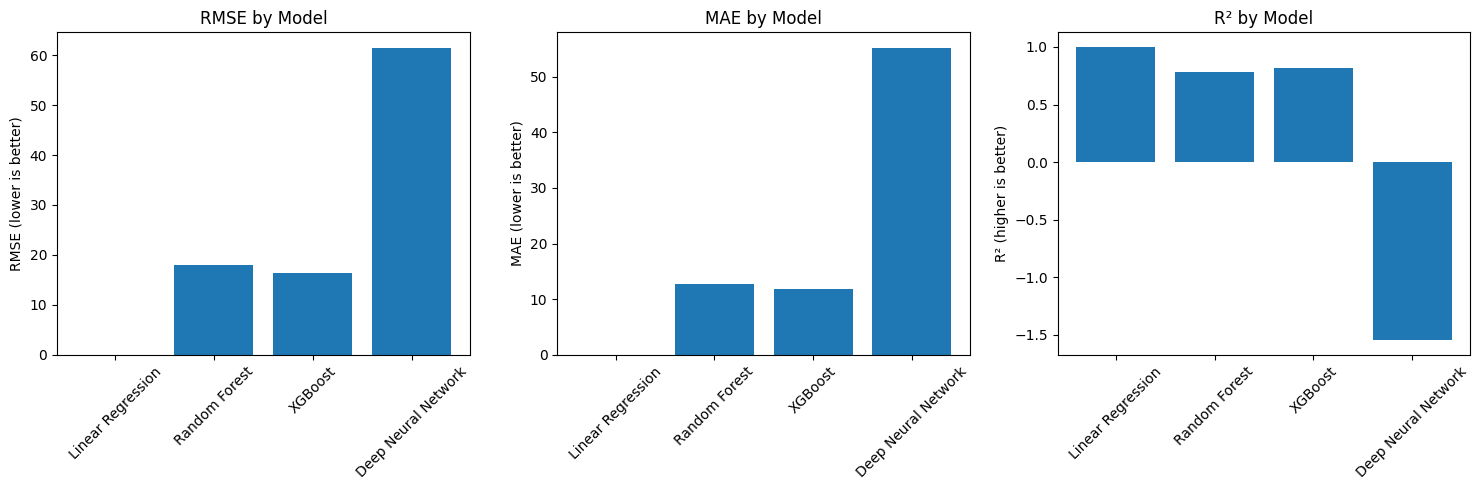

In [80]:
# 8. Compare all models
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Deep Neural Network']
rmse_scores = [lr_rmse, rf_rmse, xgb_rmse, np.sqrt(dnn_loss)]
mae_scores = [lr_mae, rf_mae, xgb_mae, dnn_mae]
r2_scores = [lr_r2, rf_r2, xgb_r2, dnn_r2]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(models, rmse_scores)
plt.title('RMSE by Model')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, mae_scores)
plt.title('MAE by Model')
plt.ylabel('MAE (lower is better)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, r2_scores)
plt.title('R² by Model')
plt.ylabel('R² (higher is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



Best performing model: Linear Regression


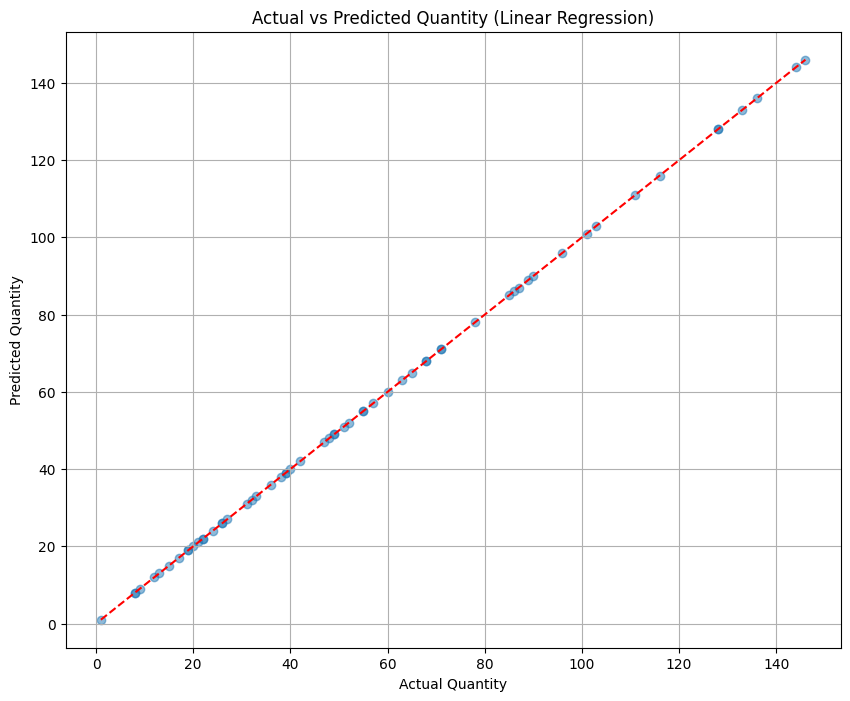

In [81]:
# 9. Plot actual vs predicted values for the best model
# Determine the best model based on R²
best_model_index = np.argmax(r2_scores)
best_model_name = models[best_model_index]
print(f"\nBest performing model: {best_model_name}")

# Get predictions from the best model
if best_model_name == 'Linear Regression':
    best_predictions = lr_predictions
elif best_model_name == 'Random Forest':
    best_predictions = rf_predictions
elif best_model_name == 'XGBoost':
    best_predictions = xgb_predictions
else:  # Deep Neural Network
    best_predictions = dnn_predictions.flatten()

# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Actual vs Predicted Quantity ({best_model_name})')
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.grid(True)
plt.show()

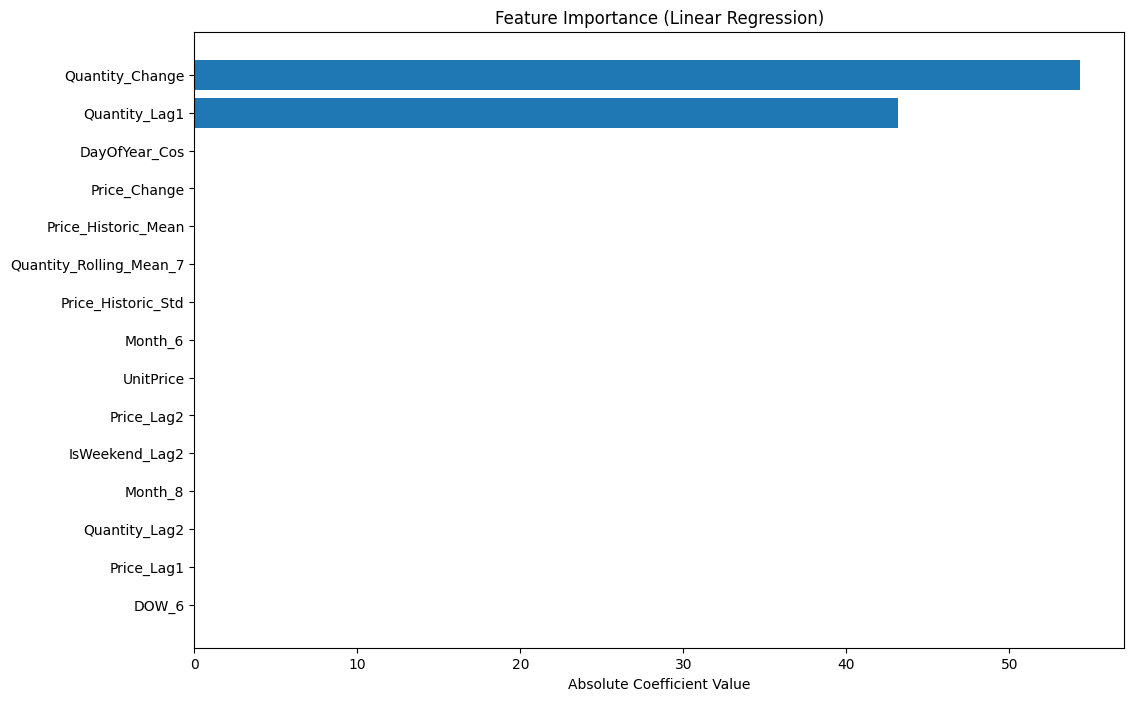

In [84]:
# 10. Feature importance analysis for the best model
# For linear regression
if best_model_name == 'Linear Regression':
    importance = np.abs(lr_model.coef_)
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
    plt.title('Feature Importance (Linear Regression)')
    plt.xlabel('Absolute Coefficient Value')
    plt.gca().invert_yaxis()
    plt.show()

# For random forest
elif best_model_name == 'Random Forest':
    importance = rf_model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.show()

# For XGBoost
elif best_model_name == 'XGBoost':
    importance = xgb_model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
    plt.title('Feature Importance (XGBoost)')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.show()

    # More detailed XGBoost feature importance plot
    xgb.plot_importance(xgb_model, max_num_features=15, height=0.8, importance_type='gain')
    plt.title('XGBoost Feature Importance (Gain)')
    plt.show()

# For DNN, we'll use SHAP values
else:
    # Sample for SHAP analysis (can be slow for large datasets)
    shap_sample_size = min(100, X_test_tensor.shape[0])
    shap_sample_indices = np.random.choice(X_test_tensor.shape[0], shap_sample_size, replace=False)
    X_shap = X_test_tensor[shap_sample_indices]

    # Create explainer
    explainer = shap.DeepExplainer(dnn_model, X_shap)
    shap_values = explainer.shap_values(X_shap)

    # Plot SHAP summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[0], X_shap, feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance (DNN)')
    plt.tight_layout()
    plt.show()


# Price Optimization

In [85]:
# 1. Define a function to calculate profit based on price and predicted quantity
def calculate_profit(price, predicted_quantity, cost_per_unit=None):
    """
    Calculate profit based on price, predicted quantity, and cost.
    If cost_per_unit is not provided, it will be estimated as 60% of the price.
    """
    if cost_per_unit is None:
        # Estimate cost as 60% of price if not provided
        cost_per_unit = 0.6 * price

    # Calculate profit
    profit = (price - cost_per_unit) * predicted_quantity

    return profit


In [86]:
# 2. Calculate the average cost per unit (estimated as 60% of the average price)
avg_price = product_data_clean['UnitPrice'].mean()
avg_cost = 0.6 * avg_price  # Estimated cost (60% of price)

print(f"Average price: £{avg_price:.2f}")
print(f"Estimated average cost: £{avg_cost:.2f}")


Average price: £2.92
Estimated average cost: £1.75


In [87]:
# 3. Define a function to predict quantity for a given price
def predict_quantity(price, model, feature_data, scaler, price_col_index):
    """
    Predict quantity sold based on a specific price while keeping other features constant.

    Parameters:
    - price: The price to simulate
    - model: Trained model (could be ML model or DNN)
    - feature_data: Base feature set (scaled)
    - scaler: Scaler used for the features
    - price_col_index: Index of the price column in the feature set

    Returns:
    - Predicted quantity
    """
    # Create a copy of the feature data
    features_copy = feature_data.copy()

    # Unscale the data to modify the price
    features_unscaled = scaler.inverse_transform(features_copy)

    # Modify the price
    features_unscaled[:, price_col_index] = price

    # Rescale the data
    features_modified = scaler.transform(features_unscaled)

    # Make prediction
    if isinstance(model, keras.Model):
        predicted_qty = model.predict(features_modified).flatten()
    else:
        predicted_qty = model.predict(features_modified)

    # Make sure the predicted quantity is not negative
    predicted_qty = np.maximum(predicted_qty, 0)

    return predicted_qty


In [88]:
# 4. Find the index of the price column
price_col_name = 'UnitPrice'
price_col_index = feature_names.index(price_col_name) if price_col_name in feature_names else -1

if price_col_index == -1:
    print("Warning: 'UnitPrice' not found in feature names. Using the first price-related feature.")
    # Find any price-related feature
    for i, name in enumerate(feature_names):
        if 'price' in name.lower():
            price_col_index = i
            break

if price_col_index == -1:
    print("Error: Could not find any price-related feature in the model features.")
else:
    print(f"Using feature '{feature_names[price_col_index]}' at index {price_col_index} for price optimization.")


Using feature 'UnitPrice' at index 0 for price optimization.


In [89]:
# 5. Define a wide range of prices to test
min_price = max(0.5 * avg_price, 0.01)  # Minimum price (50% of average)
max_price = 2 * avg_price  # Maximum price (200% of average)
price_range = np.linspace(min_price, max_price, 100)  # Test 100 different prices

In [90]:
# 6. Simulate each price and calculate the resulting profit
# Using the best model from earlier comparison
best_model = None
if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = dnn_model

# Get a sample feature set to modify (using the average of test data)
sample_features = np.mean(X_test_reduced_scaled, axis=0).reshape(1, -1)

profits = []
quantities = []

for price in price_range:
    # Predict quantity at this price
    qty = predict_quantity(price, best_model, sample_features, scaler_reduced, price_col_index)

    # Calculate profit
    profit = calculate_profit(price, qty, avg_cost)

    profits.append(float(profit))
    quantities.append(float(qty))

In [93]:
# 7. Find the optimal price that maximizes profit
profits_array = np.array(profits)
optimal_idx = np.argmax(profits_array)
optimal_price = price_range[optimal_idx]
optimal_profit = profits_array[optimal_idx]
optimal_quantity = quantities[optimal_idx]

print(f"\nOptimal pricing analysis results:")
print(f"Current average price: £{avg_price:.2f}")
print(f"Optimal price for maximum profit: £{optimal_price:.2f}")
print(f"Estimated quantity at optimal price: {optimal_quantity:.2f} units")
print(f"Maximum profit at optimal price: £{optimal_profit:.2f}")

# Calculate profit at current average price
current_qty = predict_quantity(avg_price, best_model, sample_features, scaler_reduced, price_col_index)
current_profit = calculate_profit(avg_price, current_qty, avg_cost)
print(f"Profit at current average price (£{avg_price:.2f}): £{float(current_profit[0]):.2f}") # Access the first element of the array
print(f"Profit improvement: {((optimal_profit/current_profit[0]) - 1) * 100:.2f}%") # Access the first element of the array


Optimal pricing analysis results:
Current average price: £2.92
Optimal price for maximum profit: £5.83
Estimated quantity at optimal price: 57.08 units
Maximum profit at optimal price: £233.00
Profit at current average price (£2.92): £66.57
Profit improvement: 250.00%


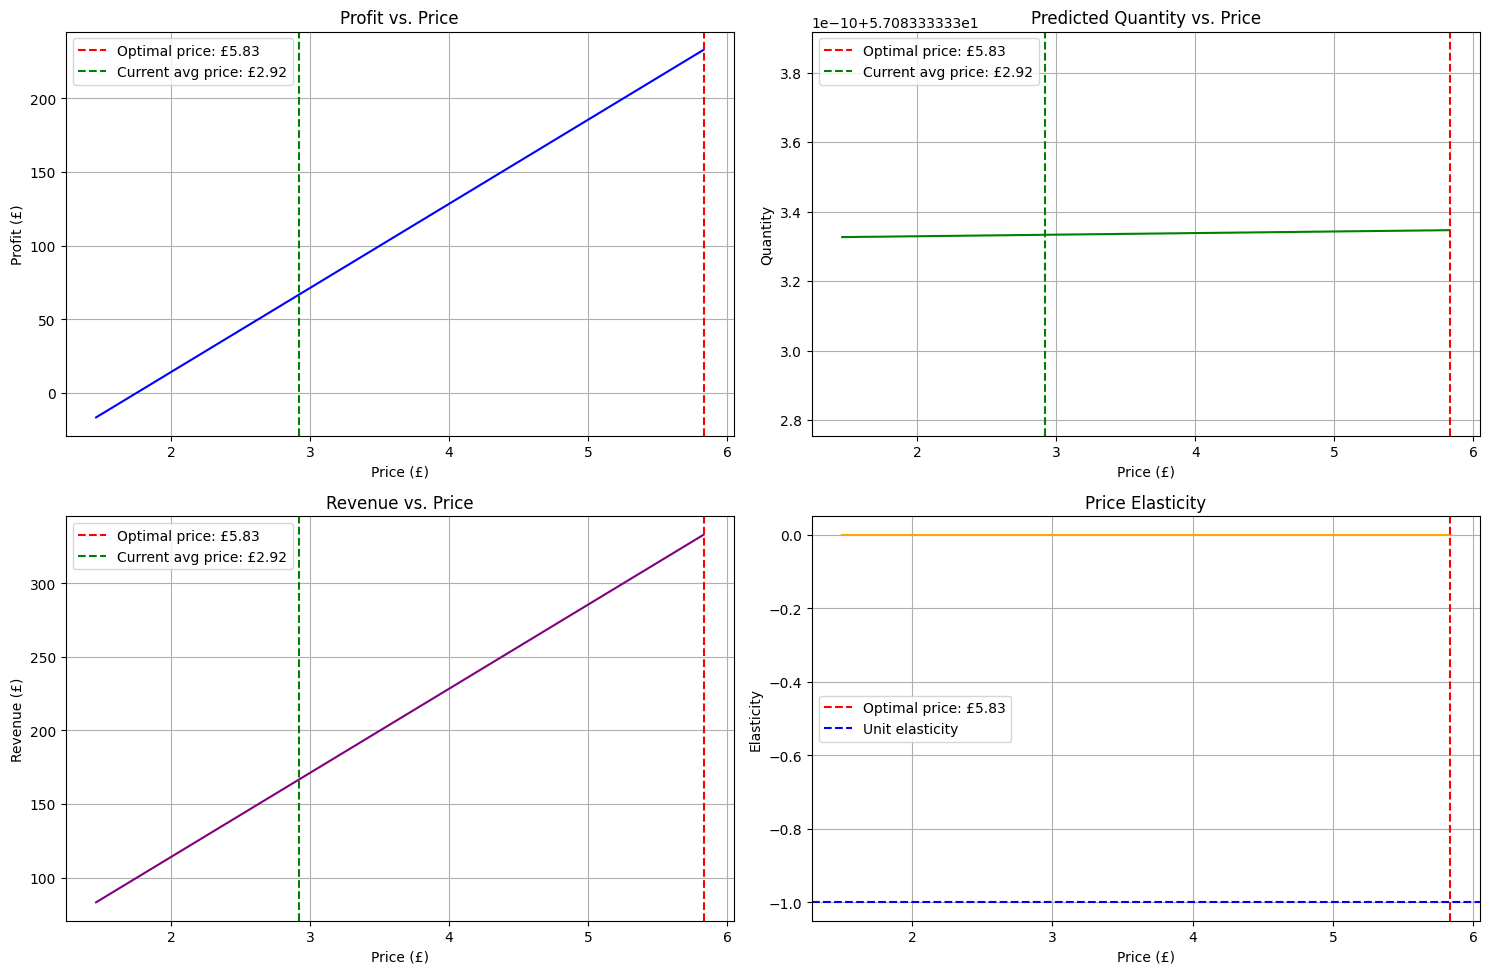

In [94]:
# 8. Visualize the price optimization results
plt.figure(figsize=(15, 10))

# Plot profit curve
plt.subplot(2, 2, 1)
plt.plot(price_range, profits, 'b-')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal price: £{optimal_price:.2f}')
plt.axvline(x=avg_price, color='g', linestyle='--', label=f'Current avg price: £{avg_price:.2f}')
plt.title('Profit vs. Price')
plt.xlabel('Price (£)')
plt.ylabel('Profit (£)')
plt.grid(True)
plt.legend()

# Plot quantity curve
plt.subplot(2, 2, 2)
plt.plot(price_range, quantities, 'g-')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal price: £{optimal_price:.2f}')
plt.axvline(x=avg_price, color='g', linestyle='--', label=f'Current avg price: £{avg_price:.2f}')
plt.title('Predicted Quantity vs. Price')
plt.xlabel('Price (£)')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

# Plot revenue curve
revenues = [p * q for p, q in zip(price_range, quantities)]
plt.subplot(2, 2, 3)
plt.plot(price_range, revenues, 'purple')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal price: £{optimal_price:.2f}')
plt.axvline(x=avg_price, color='g', linestyle='--', label=f'Current avg price: £{avg_price:.2f}')
plt.title('Revenue vs. Price')
plt.xlabel('Price (£)')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.legend()

# Plot price elasticity
# Calculate point elasticity: (% change in quantity) / (% change in price)
elasticities = []
for i in range(1, len(price_range)):
    price_pct_change = (price_range[i] - price_range[i-1]) / price_range[i-1]
    qty_pct_change = (quantities[i] - quantities[i-1]) / quantities[i-1] if quantities[i-1] > 0 else 0
    elasticity = qty_pct_change / price_pct_change if price_pct_change != 0 else 0
    elasticities.append(elasticity)

plt.subplot(2, 2, 4)
plt.plot(price_range[1:], elasticities, 'orange')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Optimal price: £{optimal_price:.2f}')
plt.axhline(y=-1, color='b', linestyle='--', label='Unit elasticity')
plt.title('Price Elasticity')
plt.xlabel('Price (£)')
plt.ylabel('Elasticity')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Price Sensitivity Analysis and Model Insights


In [95]:
# 1. Define different customer segments or scenarios to test
scenarios = {
    'Base': {'day_of_week': 2, 'is_weekend': 0, 'month': 6},  # Wednesday in June
    'Weekend': {'day_of_week': 5, 'is_weekend': 1, 'month': 6},  # Saturday in June
    'Holiday Season': {'day_of_week': 2, 'is_weekend': 0, 'month': 12},  # Wednesday in December
    'Summer Sale': {'day_of_week': 2, 'is_weekend': 0, 'month': 8},  # Wednesday in August
}

In [96]:
# 2. Create a function to generate feature vectors for different scenarios
def create_scenario_features(base_features, scenario, feature_names):
    """
    Create a feature vector for a specific scenario by modifying relevant features.

    Parameters:
    - base_features: Base feature set (scaled)
    - scenario: Dictionary with scenario parameters
    - feature_names: List of feature names

    Returns:
    - Modified feature vector
    """
    # Create a copy of the base features
    features_copy = base_features.copy()
    features_unscaled = scaler_reduced.inverse_transform(features_copy)

    # Modify features based on scenario
    for param, value in scenario.items():
        # Find all related feature indices
        for i, name in enumerate(feature_names):
            if f'DOW_{value}' in name and param == 'day_of_week':
                # Set the specific day of week to 1, others to 0
                for j in range(7):
                    dow_idx = feature_names.index(f'DOW_{j}') if f'DOW_{j}' in feature_names else -1
                    if dow_idx >= 0:
                        features_unscaled[:, dow_idx] = 1 if j == value else 0

            if name == 'IsWeekend' and param == 'is_weekend':
                idx = feature_names.index(name)
                features_unscaled[:, idx] = value

            if f'Month_{value}' in name and param == 'month':
                # Set the specific month to 1, others to 0
                for j in range(1, 13):
                    month_idx = feature_names.index(f'Month_{j}') if f'Month_{j}' in feature_names else -1
                    if month_idx >= 0:
                        features_unscaled[:, month_idx] = 1 if j == value else 0

    # Rescale the features
    features_modified = scaler_reduced.transform(features_unscaled)
    return features_modified

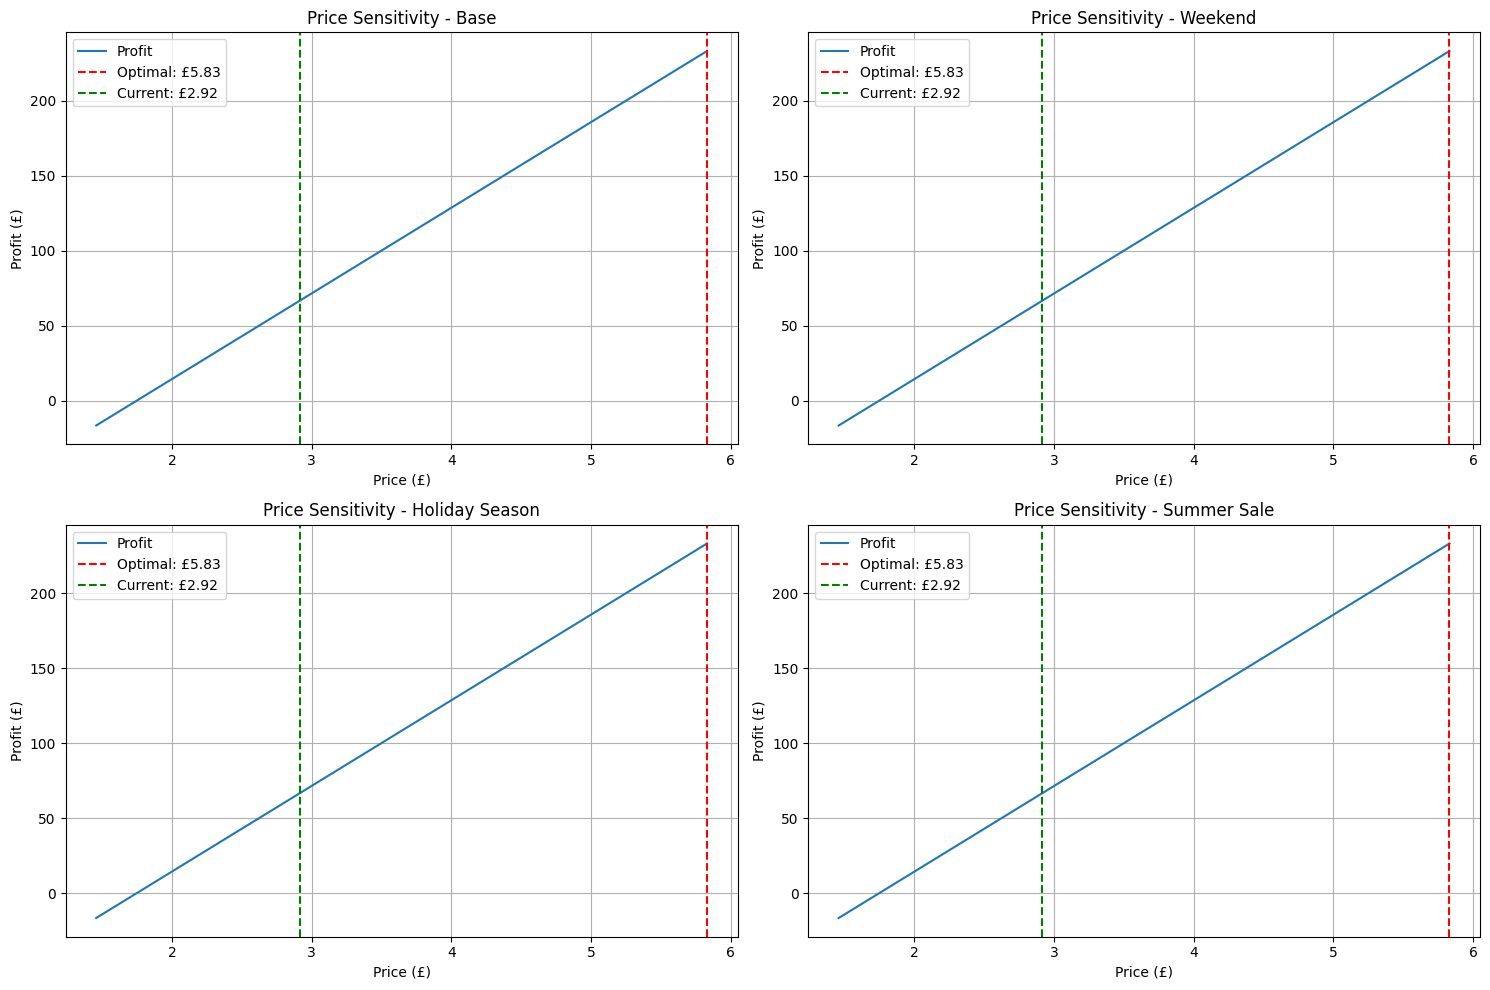

In [97]:
# 3. Analyze price sensitivity for each scenario
plt.figure(figsize=(15, 10))

optimal_prices = {}
for i, (scenario_name, params) in enumerate(scenarios.items()):
    # Create features for this scenario
    scenario_features = create_scenario_features(sample_features, params, feature_names)

    # Calculate profit for different prices
    scenario_profits = []
    scenario_quantities = []

    for price in price_range:
        qty = predict_quantity(price, best_model, scenario_features, scaler_reduced, price_col_index)
        profit = calculate_profit(price, qty, avg_cost)
        scenario_profits.append(float(profit))
        scenario_quantities.append(float(qty))

    # Find optimal price for this scenario
    optimal_idx = np.argmax(scenario_profits)
    optimal_price = price_range[optimal_idx]
    optimal_profit = scenario_profits[optimal_idx]
    optimal_prices[scenario_name] = optimal_price

    # Plot profit curve for this scenario
    plt.subplot(2, 2, i+1)
    plt.plot(price_range, scenario_profits, label=f'Profit')
    plt.axvline(x=optimal_price, color='r', linestyle='--',
                label=f'Optimal: £{optimal_price:.2f}')
    plt.axvline(x=avg_price, color='g', linestyle='--',
                label=f'Current: £{avg_price:.2f}')
    plt.title(f'Price Sensitivity - {scenario_name}')
    plt.xlabel('Price (£)')
    plt.ylabel('Profit (£)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()



Optimal prices by scenario:
Base: £5.83
Weekend: £5.83
Holiday Season: £5.83
Summer Sale: £5.83


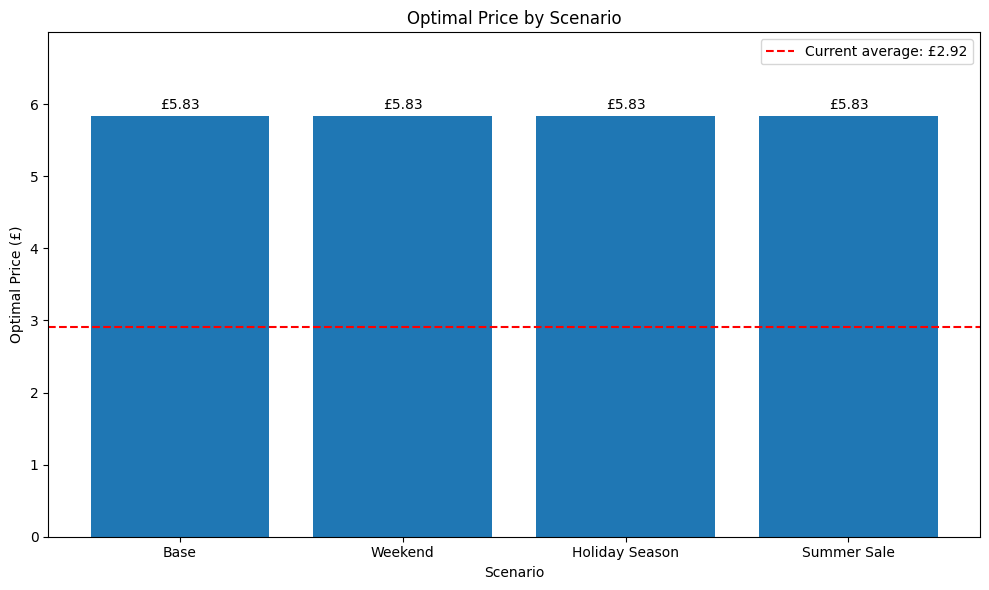

In [98]:
# 4. Compare optimal prices across scenarios
print("\nOptimal prices by scenario:")
for scenario, price in optimal_prices.items():
    print(f"{scenario}: £{price:.2f}")

# Plot optimal prices by scenario
plt.figure(figsize=(10, 6))
scenarios_list = list(optimal_prices.keys())
prices_list = list(optimal_prices.values())

plt.bar(scenarios_list, prices_list)
plt.axhline(y=avg_price, color='r', linestyle='--', label=f'Current average: £{avg_price:.2f}')
plt.title('Optimal Price by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Optimal Price (£)')
plt.ylim(0, max(prices_list) * 1.2)
for i, price in enumerate(prices_list):
    plt.text(i, price + 0.1, f'£{price:.2f}', ha='center')
plt.legend()
plt.tight_layout()
plt.show()


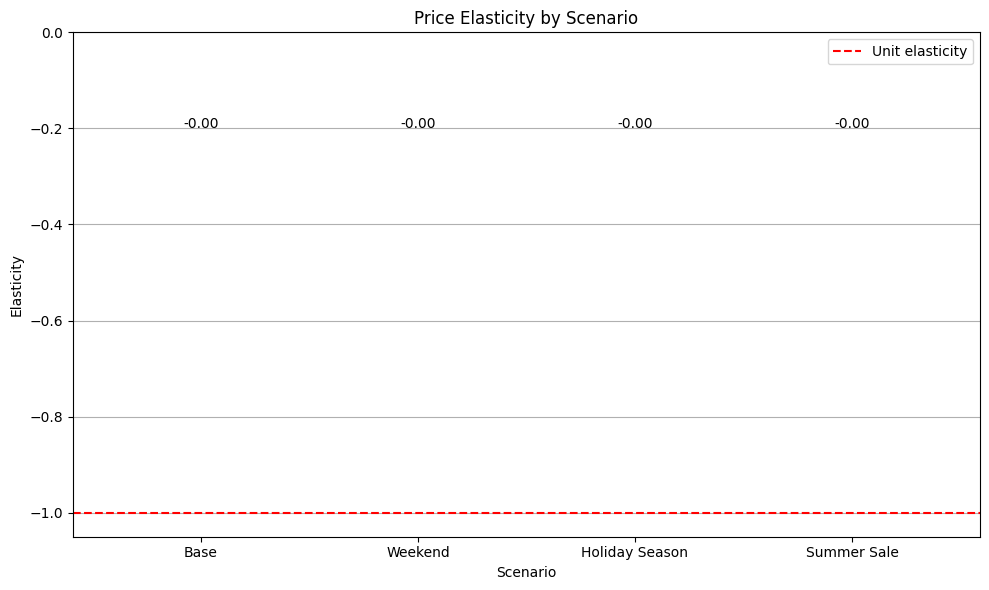


Price elasticity by scenario:
Base: -0.00 (Inelastic)
Weekend: -0.00 (Inelastic)
Holiday Season: -0.00 (Inelastic)
Summer Sale: -0.00 (Inelastic)


In [103]:
# 5. Calculate price elasticity by scenario
elasticity_by_scenario = {}

for scenario_name, params in scenarios.items():
    # Create features for this scenario
    scenario_features = create_scenario_features(sample_features, params, feature_names)

    # Calculate elasticity at current average price
    # Use a small price change of 1%
    price_up = avg_price * 1.01
    price_down = avg_price * 0.99

    qty_current = predict_quantity(avg_price, best_model, scenario_features, scaler_reduced, price_col_index)
    qty_up = predict_quantity(price_up, best_model, scenario_features, scaler_reduced, price_col_index)
    qty_down = predict_quantity(price_down, best_model, scenario_features, scaler_reduced, price_col_index)

    # Calculate elasticity using arc elasticity formula
    pct_change_price = (price_up - price_down) / ((price_up + price_down) / 2)
    pct_change_qty = (qty_down - qty_up) / ((qty_up + qty_down) / 2)
    elasticity = pct_change_qty / pct_change_price

    # Store elasticity as a scalar value
    elasticity_by_scenario[scenario_name] = elasticity[0]  # Access the first element


# Plot elasticity by scenario
plt.figure(figsize=(10, 6))
scenarios_list = list(elasticity_by_scenario.keys())
elasticity_list = list(elasticity_by_scenario.values())

plt.bar(scenarios_list, elasticity_list)
plt.axhline(y=-1, color='r', linestyle='--', label='Unit elasticity')
plt.title('Price Elasticity by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Elasticity')
for i, e in enumerate(elasticity_list):
    plt.text(i, e - 0.2, f'{e:.2f}', ha='center')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

print("\nPrice elasticity by scenario:")
for scenario, elasticity in elasticity_by_scenario.items():
    elastic_status = "Elastic" if abs(elasticity) > 1 else "Inelastic"
    print(f"{scenario}: {elasticity:.2f} ({elastic_status})")

In [104]:
# 6. Calculate the profit impact of price optimization
profit_impact = {}

for scenario_name, params in scenarios.items():
    # Create features for this scenario
    scenario_features = create_scenario_features(sample_features, params, feature_names)

    # Get optimal price for this scenario
    optimal_price = optimal_prices[scenario_name]

    # Calculate profit at current and optimal prices
    qty_current = predict_quantity(avg_price, best_model, scenario_features, scaler_reduced, price_col_index)
    profit_current = calculate_profit(avg_price, qty_current, avg_cost)

    qty_optimal = predict_quantity(optimal_price, best_model, scenario_features, scaler_reduced, price_col_index)
    profit_optimal = calculate_profit(optimal_price, qty_optimal, avg_cost)

    # Calculate improvement
    improvement = (profit_optimal / profit_current - 1) * 100 if profit_current > 0 else float('inf')
    profit_impact[scenario_name] = {
        'current_profit': float(profit_current),
        'optimal_profit': float(profit_optimal),
        'improvement': improvement
    }


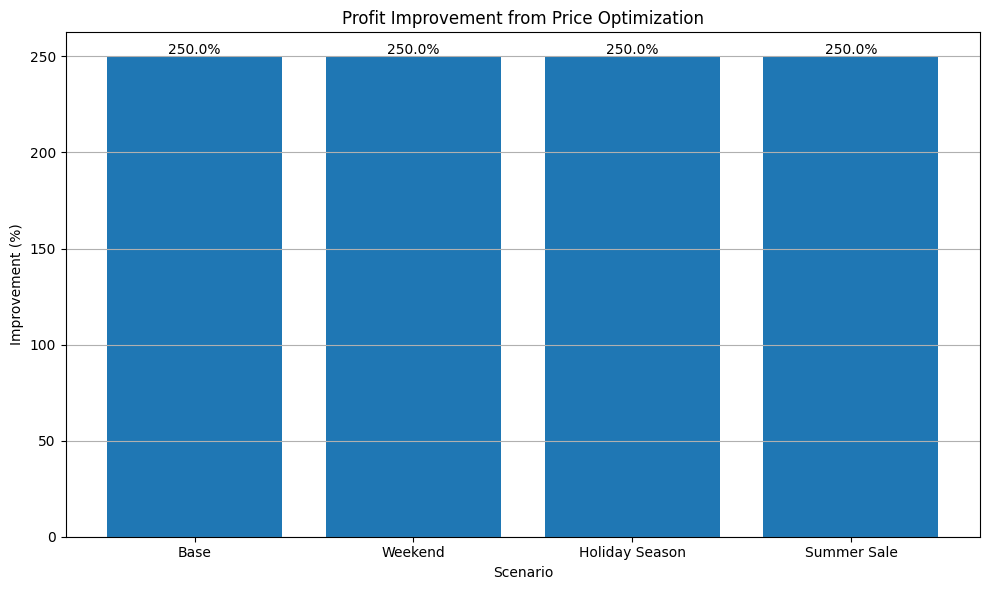

In [106]:
# Plot profit improvement
plt.figure(figsize=(10, 6))
scenarios_list = list(profit_impact.keys())
improvement_list = [data['improvement'][0] if isinstance(data['improvement'], np.ndarray) else data['improvement'] for data in profit_impact.values()] # Extract the scalar value from the numpy array

plt.bar(scenarios_list, improvement_list)
plt.title('Profit Improvement from Price Optimization')
plt.xlabel('Scenario')
plt.ylabel('Improvement (%)')
for i, imp in enumerate(improvement_list):
    plt.text(i, imp + 1, f'{imp:.1f}%', ha='center')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [108]:
print("\nProfit impact of price optimization:")
for scenario, data in profit_impact.items():
    print(f"{scenario}:")
    print(f"  Current profit: £{data['current_profit']:.2f}")
    print(f"  Optimal profit: £{data['optimal_profit']:.2f}")
    print(f"  Improvement: {data['improvement'][0]:.1f}%")


Profit impact of price optimization:
Base:
  Current profit: £66.57
  Optimal profit: £233.00
  Improvement: 250.0%
Weekend:
  Current profit: £66.57
  Optimal profit: £233.00
  Improvement: 250.0%
Holiday Season:
  Current profit: £66.57
  Optimal profit: £233.00
  Improvement: 250.0%
Summer Sale:
  Current profit: £66.57
  Optimal profit: £233.00
  Improvement: 250.0%
